In [1]:
import sys
import os
from transformers import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.set_verbosity_error()

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")

ABBR = {
    'intfloat/multilingual-e5-large-instruct': 'E5',
    'ytu-ce-cosmos/turkish-e5-large': 'COS',
    'jinaai/jina-embeddings-v3': 'JIN'
}

E0000 00:00:1746102356.377358      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746102356.445451      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda:0


In [2]:
def load_data(path):
    print(f"Loading data from: {path}")
    df = pd.read_excel(path)
    df = df.rename(columns={df.columns[0]: 'soru', df.columns[1]: 'gpt4o', df.columns[2]: 'deepseek', df.columns[3]: 'hangisi_iyi'})
    df = df.dropna(subset=['soru', 'gpt4o', 'deepseek', 'hangisi_iyi'])
    df['hangisi_iyi'] = df['hangisi_iyi'].astype(int)
    print(f"Dataset shape after cleaning: {df.shape}")
    return df

In [3]:
def encode_with_jina(texts, tokenizer, model, bsz=128):
    model.to(device).eval()
    all_embs = []
    for i in range(0, len(texts), bsz):
        batch = [str(t) for t in texts[i: i + bsz]]
        enc = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=256).to(device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            out = model(**enc)
        all_embs.append(out.last_hidden_state[:, 0, :].cpu())
    return torch.cat(all_embs, dim=0)


def compute_embeddings(df, model_name, bsz=128):
    if model_name.startswith('jina'):
        tok = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        mdl = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        S = encode_with_jina(df['soru'].tolist(), tok, mdl, bsz)
        G = encode_with_jina(df['gpt4o'].tolist(), tok, mdl, bsz)
        D = encode_with_jina(df['deepseek'].tolist(), tok, mdl, bsz)
        return S.float(), G.float(), D.float()
    else:
        mdl = SentenceTransformer(model_name)
        def enc_list(texts, desc):
            chunks = []
            for i in tqdm(range(0, len(texts), bsz), desc=desc, ncols=80):
                batch = [str(t) for t in texts[i: i + bsz]]
                chunks.append(mdl.encode(batch, convert_to_tensor=True, show_progress_bar=False))
            return torch.cat(chunks, dim=0)
        S = enc_list(df['soru'], 'Enc_S')
        G = enc_list(df['gpt4o'], 'Enc_G')
        D = enc_list(df['deepseek'], 'Enc_D')
        return S.cpu().float(), G.cpu().float(), D.cpu().float()

In [4]:
def topk_accuracy(Q, C, k):
    sim = util.cos_sim(Q, C).cpu().numpy()
    topk = np.argsort(-sim, axis=1)[:, :k]
    return np.mean([i in topk[i] for i in range(len(Q))])

In [5]:
def part_a(df, model_name, sample_size=1000):
    print(f"Running Part A for {model_name}")
    sample_df = df.sample(sample_size, random_state=42).reset_index(drop=True)
    S, G, D = compute_embeddings(sample_df, model_name)
    res = {'model': ABBR[model_name]}
    for label, M in [('G', G), ('D', D)]:
        t1 = topk_accuracy(S, M, 1)
        t5 = topk_accuracy(S, M, 5)
        res[f't1_{label}'] = t1
        res[f't5_{label}'] = t5
        print(f"  {label}: Top-1={t1:.3f}, Top-5={t5:.3f}")
    sim_mat = util.cos_sim(S, G).cpu().numpy()
    hits1 = [i in np.argsort(-sim_mat[i])[:1] for i in range(sim_mat.shape[0])]
    hits5 = [i in np.argsort(-sim_mat[i])[:5] for i in range(sim_mat.shape[0])]
    corr1 = pearsonr(hits1, sample_df['hangisi_iyi'])[0]
    corr5 = pearsonr(hits5, sample_df['hangisi_iyi'])[0]
    res['corr1'], res['corr5'] = corr1, corr5
    print(f"  Corr1={corr1:.3f}, Corr5={corr5:.3f}")
    return res

In [6]:
def part_b(df, model_names):
    print("Running Part B")
    results = []
    for m in model_names:
        print(f" Model: {m}")
        S, G, D = compute_embeddings(df, m)
        S_np, G_np, D_np = S.numpy(), G.numpy(), D.numpy()
        base = np.hstack([S_np, G_np, D_np])
        diff = np.hstack([S_np - G_np, S_np - D_np, G_np - D_np])
        norm = np.hstack([np.linalg.norm(S_np - G_np, axis=1, keepdims=True),
                          np.linalg.norm(S_np - D_np, axis=1, keepdims=True)])
        for feat_label, X in [('b', base), ('d', np.hstack([base, diff])), ('a', np.hstack([base, diff, norm]))]:
            Xtr, Xte, ytr, yte = train_test_split(X, df['hangisi_iyi'], test_size=0.2, random_state=42)
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(Xtr, ytr)
            acc = accuracy_score(yte, clf.predict(Xte))
            results.append({'model': ABBR[m], 'feat': feat_label, 'acc': acc})
            print(f"   feat={feat_label}: acc={acc:.3f}")
    return pd.DataFrame(results)

In [7]:
def plot_results(df, title, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot = df.pivot(index='model', columns='feat' if 'feat' in df.columns else 'variable',
                     values='acc' if 'acc' in df.columns else 'value')
    pivot.plot(kind='bar', ax=ax)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.tick_params(axis='x', rotation=0, labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)
    plt.legend(title='Feature' if 'feat' in df.columns else 'Variable', loc='best')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [8]:
excel_path = '/kaggle/input/ogrencisorular/ogrenci_sorular_2025.xlsx'

df = load_data(excel_path)

ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f"res_{ts}"
os.makedirs(results_dir, exist_ok=True)

models = list(ABBR.keys())
a_results = [part_a(df, m) for m in models]
pa_df = pd.DataFrame(a_results)

pa_df.to_csv(os.path.join(results_dir, 'part_a.csv'), index=False)

Loading data from: /kaggle/input/ogrencisorular/ogrenci_sorular_2025.xlsx
Dataset shape after cleaning: (13891, 4)
Running Part A for intfloat/multilingual-e5-large-instruct


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Enc_D: 100%|██████████████████████████████████████| 8/8 [00:24<00:00,  3.01s/it]


  G: Top-1=0.776, Top-5=0.936
  D: Top-1=0.736, Top-5=0.883
  Corr1=-0.025, Corr5=-0.049
Running Part A for ytu-ce-cosmos/turkish-e5-large


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.40k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Enc_D: 100%|██████████████████████████████████████| 8/8 [00:24<00:00,  3.09s/it]


  G: Top-1=0.777, Top-5=0.941
  D: Top-1=0.724, Top-5=0.887
  Corr1=-0.020, Corr5=0.022
Running Part A for jinaai/jina-embeddings-v3


tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

/tmp/ipykernel_19/3088896899.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


  G: Top-1=0.892, Top-5=0.973
  D: Top-1=0.839, Top-5=0.951
  Corr1=0.006, Corr5=-0.029


In [9]:
b_df = part_b(df, models)

pb_df = b_df.rename(columns={'acc':'value','feat':'variable'})
pb_df.to_csv(os.path.join(results_dir, 'part_b.csv'), index=False)

Running Part B
 Model: intfloat/multilingual-e5-large-instruct


Enc_D: 100%|██████████████████████████████████| 109/109 [05:40<00:00,  3.12s/it]


   feat=b: acc=0.514
   feat=d: acc=0.516
   feat=a: acc=0.519
 Model: ytu-ce-cosmos/turkish-e5-large


Enc_D: 100%|██████████████████████████████████| 109/109 [05:45<00:00,  3.17s/it]


   feat=b: acc=0.512
   feat=d: acc=0.521
   feat=a: acc=0.515
 Model: jinaai/jina-embeddings-v3


/tmp/ipykernel_19/3088896899.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


   feat=b: acc=0.514
   feat=d: acc=0.511
   feat=a: acc=0.508


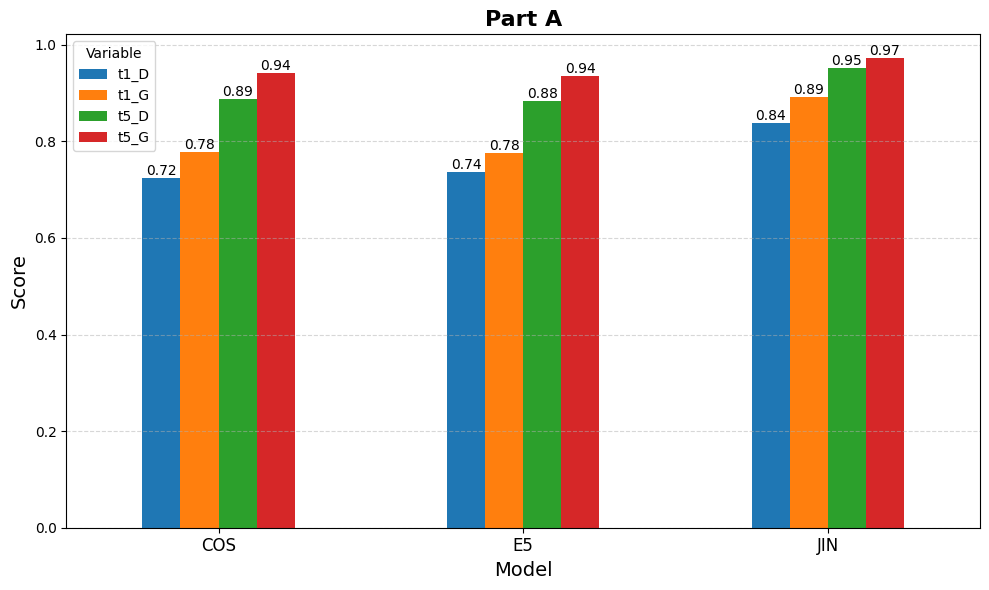

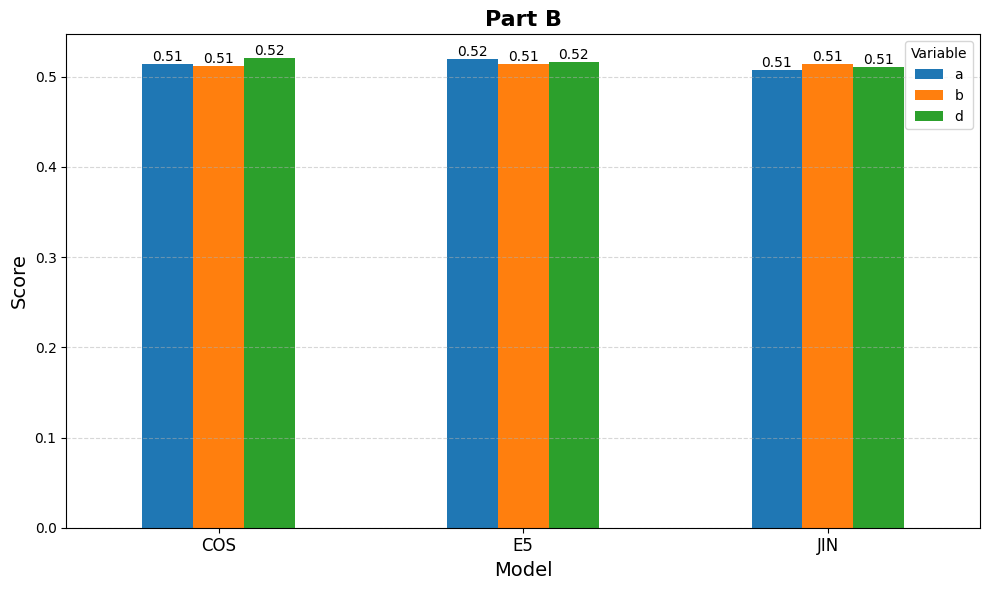

In [10]:
plot_results(pa_df.melt(id_vars='model', value_vars=['t1_G','t5_G','t1_D','t5_D']), 'Part A', save_path=os.path.join(results_dir, 'part_a.png'))
plot_results(pb_df, 'Part B', save_path=os.path.join(results_dir, 'part_b.png'))